In [ ]:
# @inproceedings{barbieri-etal-2020-tweeteval,
#     title = "{T}weet{E}val: Unified Benchmark and Comparative Evaluation for Tweet Classification",
#     author = "Barbieri, Francesco  and
#       Camacho-Collados, Jose  and
#       Espinosa Anke, Luis  and
#       Neves, Leonardo",
#     booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2020",
#     month = nov,
#     year = "2020",
#     address = "Online",
#     publisher = "Association for Computational Linguistics",
#     url = "https://aclanthology.org/2020.findings-emnlp.148",
#     doi = "10.18653/v1/2020.findings-emnlp.148",
#     pages = "1644--1650"
# }

In [ ]:
%pip install datasets transformers[sentencepiece]
# %pip install tensorflow
%pip install evaluate
%pip install scikit-learn
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

import evaluate
from evaluate import evaluator

import pandas as pd
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-06 20:24:10.509672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736195050.577854    5142 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736195050.599530    5142 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 20:24:10.760965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [ ]:
dataset = pd.read_csv('out2.csv')
dataset

,text,labels
0,my favourit food is anyth i didn t have to coo...,4
1,now if he doe off himself everyon will think h...,4
2,whi the fuck is bayless iso,0
3,to make her feel threaten,2
4,dirti southern wanker,0
...,...,...
44518,thank i wa diagnos with bp <NUMBER1> after t...,3
44519,well that make sens,3
44520,daddi issu name,4
44521,so glad i discov that subreddit a coupl month ...,3


In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.1, stratify=dataset['labels'], random_state=42)

# Subdividimos train en el propio train y datos para la validación
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['labels'], random_state=3)

In [ ]:
print(train_data.head())
print(validation_data.head())
print(test_data.head())

                                                    text  labels
27409  we ve allway a ear to rent you here in reddit ...       3
13991  no you are just suggest someon be at the perfe...       4
7351   :face_with_tears_of_joy <> face_with_tears_of_...       3
21022           you first make it more interest than thi       6
5217               i guess you’v becom someth of an icon       4
                                                    text  labels
28161                                 definit bitter lol       3
21371                                      i just see ye       3
8280   i just don t see how thi movi wouldn t get dul...       0
19138             get your nose hair wax trust me on thi       3
16476      how come you shock the spinach in an ice bath       6
                                                    text  labels
4999   dear down voter go to your own sub and take yo...       0
33829  he s shoot veri effici too most of hi fg score...       3
5526   i feel like i m in

In [ ]:
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

huggingface_dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 32056
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 8014
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 4453
    })
})

In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained('./roberta_3_finetuned_model')
reloaded_model = TFAutoModelForSequenceClassification.from_pretrained('./roberta_3_finetuned_model')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./roberta_3_finetuned_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
def tokenize_function(examples):
    return reloaded_tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_datasets.column_names

Map: 100%|██████████| 4453/4453 [00:00<00:00, 16180.52 examples/s]


{'train': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask'],
 'validation': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask'],
 'test': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask']}

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['text', '__index_level_0__'])
tokenized_datasets = tokenized_datasets.with_format('tensorflow')
tokenized_datasets['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 32056
})

In [ ]:
train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask',],
    label_cols=['labels'],
    shuffle=True,
    batch_size=8)

validation_dataset = tokenized_datasets['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=8)

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
import transformers
from transformers import AdamWeightDecay

num_epochs = 3
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)

reloaded_model.compile(optimizer=optimizer, loss=loss, metrics=['sparse_categorical_accuracy'])

In [ ]:
history = reloaded_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=num_epochs,
  steps_per_epoch=len(train_dataset),
  validation_steps=len(validation_dataset)
)

Epoch 1/3
4007/4007 [==============================] - 2265s 563ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.7862 - val_loss: 0.9988 - val_sparse_categorical_accuracy: 0.6728
Epoch 2/3
4007/4007 [==============================] - 2272s 567ms/step - loss: 0.5044 - sparse_categorical_accuracy: 0.8244 - val_loss: 1.0191 - val_sparse_categorical_accuracy: 0.6670
Epoch 3/3
4007/4007 [==============================] - 2270s 567ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8466 - val_loss: 1.1729 - val_sparse_categorical_accuracy: 0.6452


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


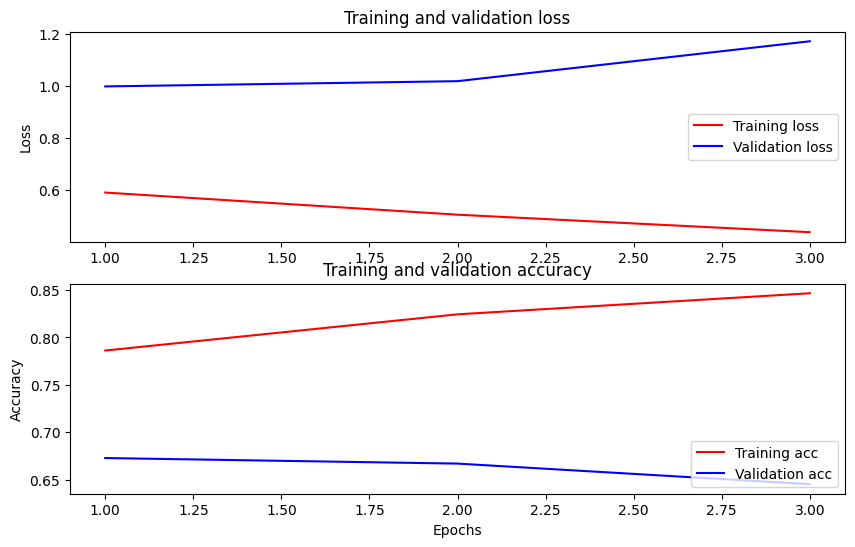

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'feelnet-ROBERTA-6'
saved_model_path = './{}_huggingface'.format(dataset_name.replace('/', '_'))

reloaded_model.save(saved_model_path, include_optimizer=True)

INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-6_huggingface/assets


INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-6_huggingface/assets


In [ ]:
reloaded_model.save_pretrained('./roberta_6_finetuned_model')
reloaded_tokenizer.save_pretrained('./roberta_6_finetuned_model')

('./roberta_6_finetuned_model/tokenizer_config.json',
 './roberta_6_finetuned_model/special_tokens_map.json',
 './roberta_6_finetuned_model/vocab.json',
 './roberta_6_finetuned_model/merges.txt',
 './roberta_6_finetuned_model/added_tokens.json',
 './roberta_6_finetuned_model/tokenizer.json')

In [ ]:
## Recuperar el modelo guardado con model.save
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
## Recuperar el modelo guardado con save_pretrained
reloaded_tokenizer = AutoTokenizer.from_pretrained('./roberta_6_finetuned_model')
reloaded_model = TFAutoModelForSequenceClassification.from_pretrained('./roberta_6_finetuned_model')